In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt 
import pandas as pd
import os
from PIL import Image

In [46]:
from Pruning.laprune import LAP 

In [79]:
data = pd.read_csv('/Users/anureddy/Desktop/SEM03/Generative_NN_for_the_Sciences/Project_proposal/GNNProject/DataPreparation/CorruptedData/Names.csv')

In [80]:
class FashionMNISTDataset(Dataset):
    def __init__(self,dataframe,root_dir,transform=None):
        self.dataframe=dataframe
        self.root_dir = root_dir
        self.transform=transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.dataframe.iloc[idx,0])
        image=Image.open(img_name)
        label=self.dataframe.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,image

In [81]:
transform = transforms.ToTensor()

In [82]:
root_dir = '/Users/anureddy/Desktop/SEM03/Generative_NN_for_the_Sciences/Project_proposal/GNNProject/DataPreparation/CorruptedData'
dataset = FashionMNISTDataset(dataframe=data,root_dir=root_dir,transform=transform)

In [83]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.1*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset = random_split(dataset,[train_size,validation_size,test_size])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

48000
6000


In [85]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_sizes, layers):
        super().__init__()
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_sizes = hidden_sizes
        self.layers = layers
        self.hidden_layers_encoder = []
        self.hidden_layers_decoder = []

        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.output_layer = nn.Linear(hidden_sizes[0], input_size)
        self.bottleneck_layer = nn.Linear(hidden_sizes[-1], bottleneck_size)

        self.hidden_layers_decoder.append(nn.Linear(bottleneck_size,hidden_sizes[-1]))
        self.hidden_layers_decoder.append(nn.ReLU())
        for i in range(1, layers):
            self.hidden_layers_encoder.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.hidden_layers_encoder.append(nn.ReLU())
        for i in reversed(range(1, layers)):
            self.hidden_layers_decoder.append(nn.Linear(hidden_sizes[i], hidden_sizes[i-1]))
            self.hidden_layers_decoder.append(nn.ReLU())

        #self.hidden_layers_encoder.append(nn.Linear(hidden_size, bottleneck_size))

        self.encoder = nn.Sequential(self.input_layer,
                                     nn.ReLU(),
                                     *self.hidden_layers_encoder,
                                     self.bottleneck_layer)

        self.decoder = nn.Sequential(
                                    *self.hidden_layers_decoder,
                                     self.output_layer)

        self.model = nn.Sequential(self.encoder, self.decoder)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

    def calculate_loss(self, X):
        error_type = nn.MSELoss()
        reconstructed = self.forward(X)
        loss = error_type(reconstructed, X)
        return loss

    def train_autoencoder(self, train_loader, val_loader, epochs, lr=0.01):
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            criterion = nn.MSELoss()
            train_losses = []
            val_losses = []

            for epoch in range(epochs):
                self.train()  # Set model to training mode
                total_train_loss = 0
                for X_batch, _ in train_loader:
                    X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                    optimizer.zero_grad()
                    outputs = self(X_batch)
                    train_loss = criterion(outputs, X_batch)
                    train_loss.backward()
                    optimizer.step()
                    total_train_loss += train_loss.item()
                avg_train_loss = total_train_loss / len(train_loader)
                train_losses.append(avg_train_loss)

                # Validation
                self.eval()  # Set model to evaluation mode
                total_val_loss = 0
                with torch.no_grad():
                    for X_batch, _ in val_loader:
                        X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                        outputs = self(X_batch)
                        val_loss = criterion(outputs, X_batch)
                        total_val_loss += val_loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                val_losses.append(avg_val_loss)

                print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

            return train_losses, val_losses

In [ ]:
# Hyperparameters
hidden_sizes_options = [[128], [256, 128], [512, 256, 128]]
learning_rate_options = [0.01, 0.001]
epochs_options = [5, 10]
bottleneck_sizes = [64, 32]

best_val_loss = float('inf')
best_params = {}

for hidden_sizes in hidden_sizes_options:
    for lr in learning_rate_options:
        for epochs in epochs_options:
            for bottleneck_size in bottleneck_sizes:
                # Calculate 'layers' based on the length of hidden_sizes
                layers = len(hidden_sizes)
                
                # Adjusted model instantiation to include 'layers'
                model = AutoEncoder(input_size=784, bottleneck_size=bottleneck_size, hidden_sizes=hidden_sizes, layers=layers)
                print(f'Training with hidden_sizes={hidden_sizes}, lr={lr}, epochs={epochs}, bottleneck_size={bottleneck_size}, layers={layers}')
                
                # Updated to capture the return value correctly
                train_losses, val_losses = model.train_autoencoder(train_dataloader, validation_dataloader, epochs, lr)
                
                # Assuming you want to consider the last validation loss for comparison
                last_val_loss = val_losses[-1]
                if last_val_loss < best_val_loss:
                    best_val_loss = last_val_loss
                    best_params = {
                        'hidden_sizes': hidden_sizes,
                        'learning_rate': lr,
                        'epochs': epochs,
                        'bottleneck_size': bottleneck_size,
                        'layers': layers  # Keep track of the 'layers' in best parameters
                    }

print(f'Best Parameters: {best_params}')

In [86]:
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = model.train_autoencoder(train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.0134, Val Loss: 0.0045
Epoch 2, Train Loss: 0.0038, Val Loss: 0.0033
Epoch 3, Train Loss: 0.0028, Val Loss: 0.0027
Epoch 4, Train Loss: 0.0026, Val Loss: 0.0024
Epoch 5, Train Loss: 0.0023, Val Loss: 0.0023
Epoch 6, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 7, Train Loss: 0.0020, Val Loss: 0.0020
Epoch 8, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 9, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 10, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 11, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 12, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 13, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 14, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 15, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 16, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 17, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 18, Train Loss: 0.0015, Val Loss: 0.0016
Epoch 19, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 20, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 21, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 22, Train Loss: 

In [54]:
def eval_model(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.view(X_batch.size(0), -1)
            outputs = model(X_batch)
            loss = criterion(outputs, X_batch)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss


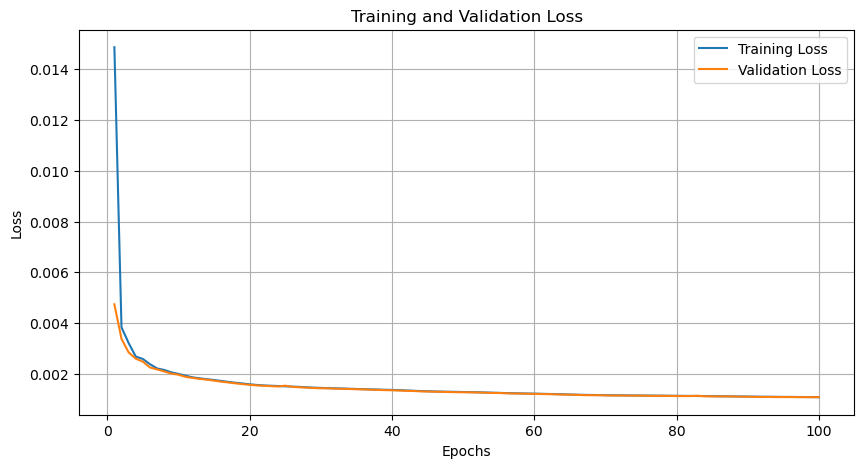

In [55]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataloader)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.0012
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.0017
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.0031
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.0060
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.0116
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.0229
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.0629
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1457


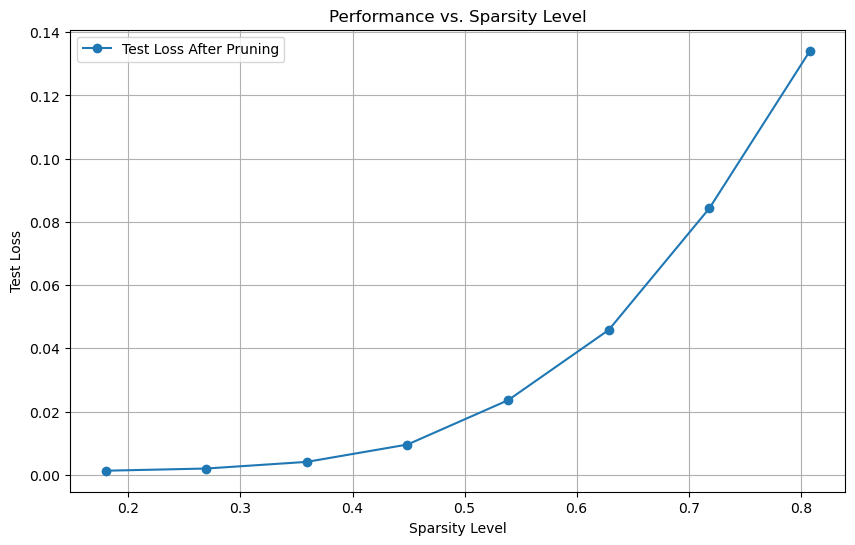

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, test_losses, '-o', label='Test Loss After Pruning')
plt.xlabel('Sparsity Level')
plt.ylabel('Test Loss')
plt.title('Performance vs. Sparsity Level')
plt.legend()
plt.grid(True)
plt.show()

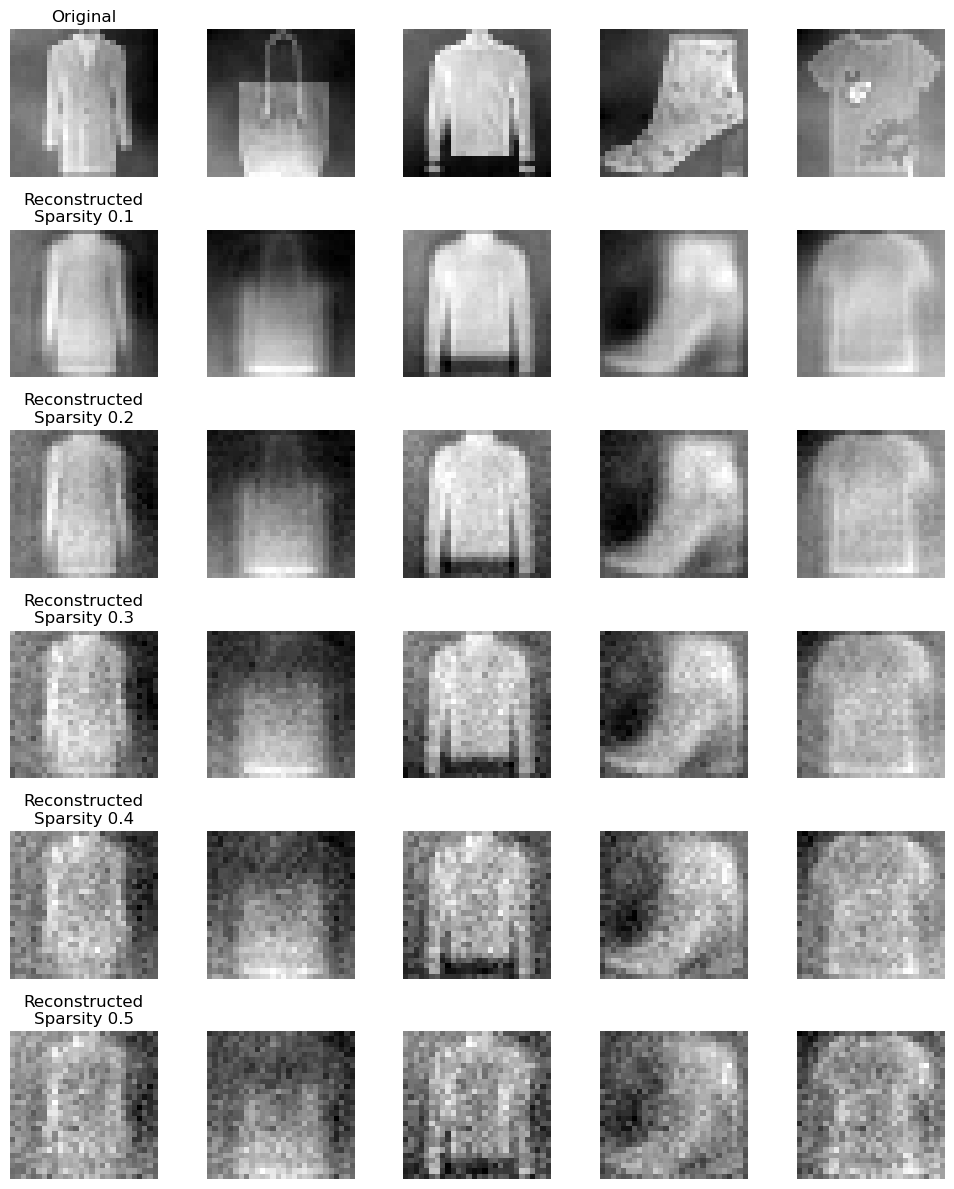

In [88]:
import matplotlib.pyplot as plt
import torch
import copy

def display_reconstructed_images(model, test_dataloader, prune_ratios):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(prune_ratios, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        apply_lap(pruned_model, [sparsity] * len(pruned_model.hidden_sizes), bn_factors=None)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

# Assuming 'model' is the trained AutoEncoder, 'test_dataloader' is defined,
# and 'prune_ratios' is a list of desired sparsity levels
display_reconstructed_images(model, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5])


In [89]:
data = pd.read_csv('/Users/anureddy/Desktop/CorruptedMNIST/CorruptedMNIST/Names.csv')

In [90]:
class MNISTDataset(Dataset):
    def __init__(self,dataframe,root_dir,transform=None):
        self.dataframe=dataframe
        self.root_dir = root_dir
        self.transform=transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.dataframe.iloc[idx,0])
        image=Image.open(img_name)
        label=self.dataframe.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,image

In [91]:
transform = transforms.ToTensor()

In [92]:
data = pd.read_csv('/Users/anureddy/Desktop/CorruptedMNIST/CorruptedMNIST/Names.csv')

In [93]:
root_dir = '/Users/anureddy/Desktop/CorruptedMNIST/CorruptedMNIST'
dataset = FashionMNISTDataset(dataframe=data,root_dir=root_dir,transform=transform)

In [94]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.1*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset = random_split(dataset,[train_size,validation_size,test_size])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

48000
6000


In [95]:
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = model.train_autoencoder(train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.0119, Val Loss: 0.0046
Epoch 2, Train Loss: 0.0045, Val Loss: 0.0043
Epoch 3, Train Loss: 0.0040, Val Loss: 0.0037
Epoch 4, Train Loss: 0.0034, Val Loss: 0.0033
Epoch 5, Train Loss: 0.0030, Val Loss: 0.0029
Epoch 6, Train Loss: 0.0028, Val Loss: 0.0027
Epoch 7, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 8, Train Loss: 0.0025, Val Loss: 0.0025
Epoch 9, Train Loss: 0.0024, Val Loss: 0.0024
Epoch 10, Train Loss: 0.0023, Val Loss: 0.0023
Epoch 11, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 12, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 13, Train Loss: 0.0020, Val Loss: 0.0020
Epoch 14, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 15, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 16, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 17, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 18, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 19, Train Loss: 0.0018, Val Loss: 0.0017
Epoch 20, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 21, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 22, Train Loss: 

In [97]:
def eval_model(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.view(X_batch.size(0), -1)
            outputs = model(X_batch)
            loss = criterion(outputs, X_batch)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss


In [98]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataloader)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.0013
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.0017
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.0032
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.0073
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.0159
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.0346
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.0703
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1233


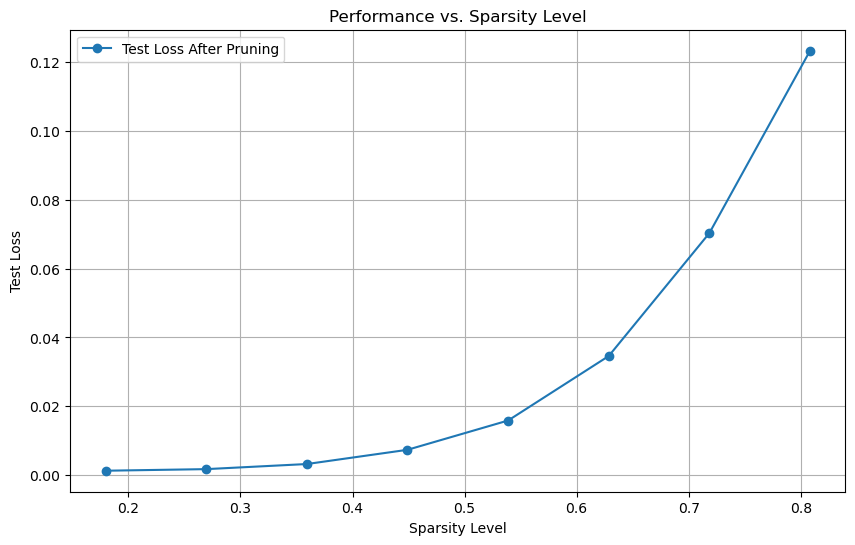

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, test_losses, '-o', label='Test Loss After Pruning')
plt.xlabel('Sparsity Level')
plt.ylabel('Test Loss')
plt.title('Performance vs. Sparsity Level')
plt.legend()
plt.grid(True)
plt.show()

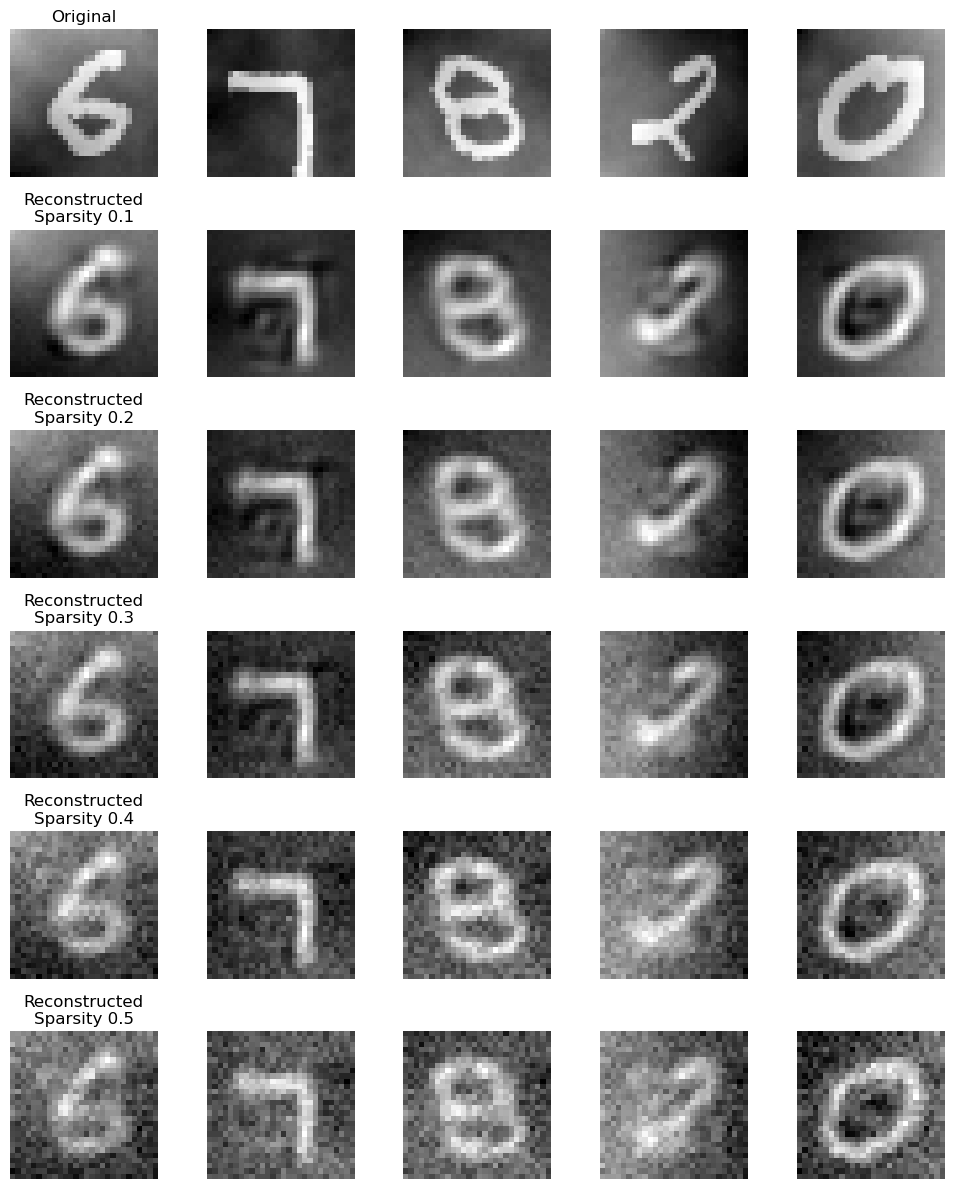

In [100]:
import matplotlib.pyplot as plt
import torch
import copy

def display_reconstructed_images(model, test_dataloader, prune_ratios):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(prune_ratios, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        apply_lap(pruned_model, [sparsity] * len(pruned_model.hidden_sizes), bn_factors=None)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()


display_reconstructed_images(model, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5])
